In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, physics_category_labels, physics_category_colors


In [2]:
print("loading all_df.pkl...")
with open(f"../intermediate_files/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/first_multiclass_training/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


loading all_df.pkl...
all_df.shape=(747332, 52)
loading predictions.pkl...
pred_df.shape=(71178, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500
merged_df.shape=(35589, 70)
presel_merged_df.shape=(24065, 70)


,run,subrun,event,filetype,wc_net_weight,topological_signal_category,physics_signal_category,wc_nue_score,wc_numu_score,wc_nc_delta_score,...,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_2g_outFV,prob_1eNp,prob_1e0p,prob_0g,prob_3plusg,prob_dirt,prob_ext
0,20290,30,1510,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-15.000000,-0.445759,-3.342609,...,0.006847,0.009146,1.081974e-05,3.884699e-05,5.019382e-06,7.852225e-07,0.005227,0.001669,0.000011,0.005612
1,20290,30,1521,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-8.405992,-0.906318,-6.305526,...,0.004323,0.063918,1.342900e-05,2.552547e-05,2.232923e-05,2.734646e-06,0.002216,0.001291,0.000004,0.000742
4,20290,30,1543,nc_pi0_overlay,0.853012,2g0p,NC1pi0_0p,-9.779932,-1.000641,-7.236095,...,0.831766,0.023014,1.413385e-04,8.495483e-04,1.020405e-05,2.869084e-05,0.014845,0.002407,0.000193,0.007258
5,20290,30,1544,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-15.000000,-0.130912,1.638694,...,0.038636,0.001303,1.404332e-05,4.507262e-05,8.848031e-07,2.979955e-06,0.077666,0.005533,0.000078,0.007495
7,20672,75,3754,nc_pi0_overlay,0.853012,2gNp,NC1pi0_Np,-13.695713,-0.727442,-3.236898,...,0.634687,0.004054,4.241187e-05,3.152163e-04,2.066585e-05,3.048997e-05,0.000251,0.000788,0.000134,0.037318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745925,21127,121,6058,ext,15.323285,ext,ext,-15.000000,-0.032794,-3.114151,...,0.000169,0.000134,1.342654e-06,2.752117e-07,5.270298e-07,4.263510e-07,0.172643,0.000005,0.000497,0.825894
746371,20423,551,27581,ext,15.323285,ext,ext,-15.000000,-0.938013,-1.905209,...,0.013221,0.000027,2.734492e-07,1.420852e-06,4.016211e-06,2.587747e-06,0.055065,0.000005,0.906457,0.019830
746558,20194,192,9622,ext,15.323285,ext,ext,-15.000000,-3.454599,-4.554944,...,0.000866,0.000002,5.917553e-07,2.057725e-05,2.159502e-05,7.342857e-07,0.003240,0.000039,0.355974,0.636379
746934,20154,269,13456,ext,15.323285,ext,ext,-15.000000,-0.014429,-5.872269,...,0.008791,0.000075,3.397479e-05,4.497440e-07,3.394442e-06,2.769003e-06,0.069680,0.000078,0.000333,0.915805


In [3]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()

reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)

presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_90802/4263806371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


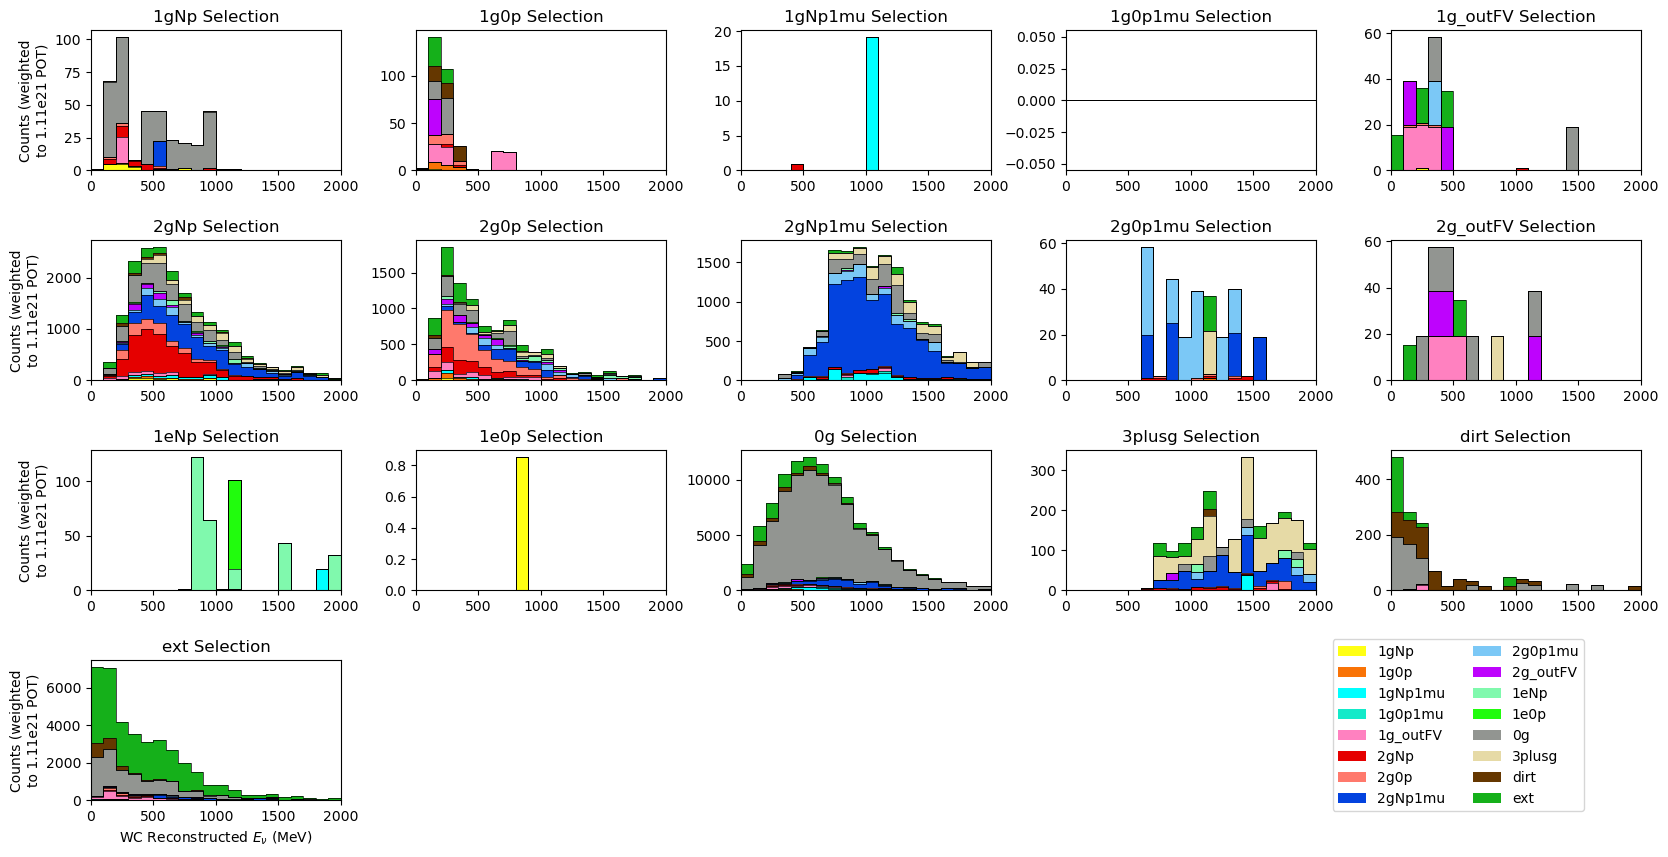

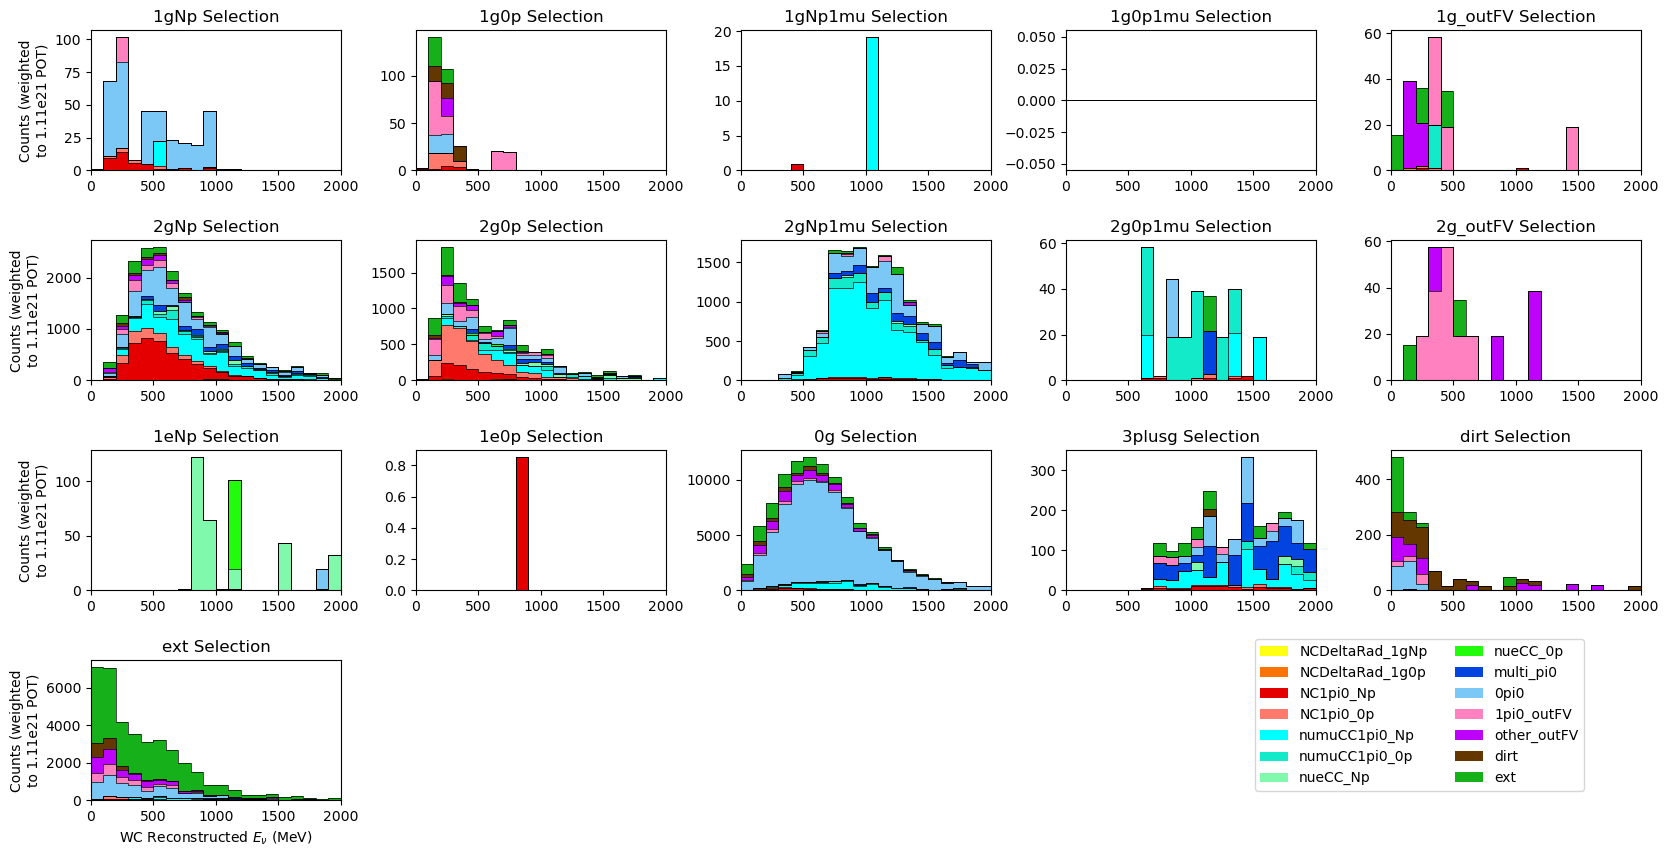

In [4]:
reco_category_queries = []
for i, signal_category in enumerate(sig_categories):
    reco_category_queries.append(f"reco_category_argmax_index == {i}")
    
for breakdown_type in ["topological", "physics"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)

    for i, signal_category in enumerate(sig_categories):

        sel_df = presel_merged_df.query(reco_category_queries[i])

        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])

        axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
        
        if i >= 15: # Only show x-label for bottom row
            axs[i].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        if i % 5 == 0: # Only show y-label for leftmost column
            axs[i].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
        axs[i].set_title(f"{signal_category} Selection")
        axs[i].set_xlim(0, 2000)
        
        if i == 15:
            axs[i].legend(ncol=2, loc='upper right', bbox_to_anchor=(6, 1.2))

    axs[16].remove()
    axs[17].remove()
    axs[18].remove()
    axs[19].remove()

    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    plt.show()


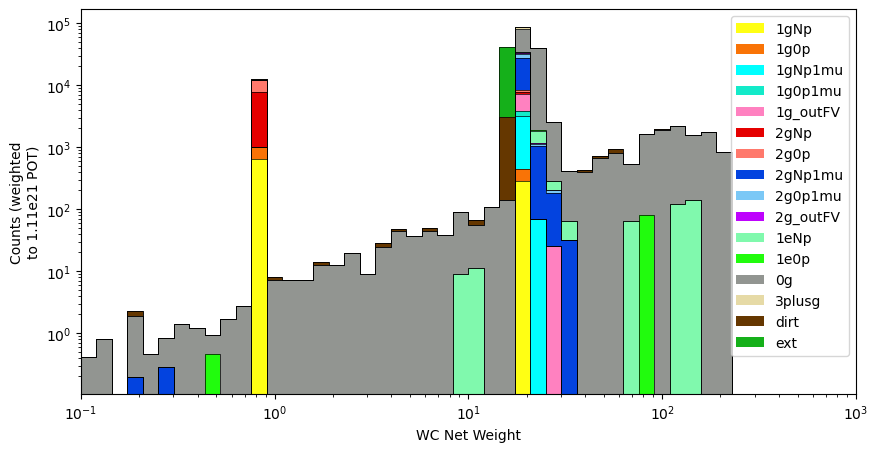

In [27]:

breakdown_labels = topological_category_labels
breakdown_colors = topological_category_colors
breakdown_queries = []
for label in breakdown_labels:
    breakdown_queries.append(f"topological_signal_category == '{label}'")

plt.figure(figsize=(10, 5))

bins = np.logspace(-1, 3, 51)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(breakdown_labels)
outline_colors = ["k"] * len(breakdown_labels)

sel_df = presel_merged_df
counts = []
for breakdown_i, breakdown_label in enumerate(breakdown_labels):
    curr_df = sel_df.query(breakdown_queries[breakdown_i])
    counts.append(np.histogram(curr_df["wc_net_weight"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)

plt.xlabel(r"WC Net Weight")
plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
plt.xlim(bins[0], bins[-1])
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


In [ ]:
# TODO: color the histograms by filetype


breakdown_labels = topological_category_labels
breakdown_colors = topological_category_colors
breakdown_queries = []
for label in breakdown_labels:
    breakdown_queries.append(f"topological_signal_category == '{label}'")

plt.figure(figsize=(10, 5))

bins = np.logspace(-1, 3, 51)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(breakdown_labels)
outline_colors = ["k"] * len(breakdown_labels)

sel_df = presel_merged_df
counts = []
for breakdown_i, breakdown_label in enumerate(breakdown_labels):
    curr_df = sel_df.query(breakdown_queries[breakdown_i])
    counts.append(np.histogram(curr_df["wc_net_weight"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)

plt.xlabel(r"WC Net Weight")
plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
plt.xlim(bins[0], bins[-1])
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()
